In [1]:
!pip install scikit-learn opencv-python matplotlib timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attempt

# **Notebook Setup**

In [2]:
import random
from random import sample
import argparse
import numpy as np
import os
from types import SimpleNamespace
import pickle
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis
from scipy.ndimage import gaussian_filter
from skimage import morphology
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2, resnet18

In [3]:
# device setup
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [4]:
%%writefile btad.py
import os
from enum import Enum

import PIL
import torch
from torchvision import transforms

_CLASSNAMES = [
    "01",
    "02",
    "03"
]

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


class DatasetSplit(Enum):
    TRAIN = "train"
    VAL = "val"
    TEST = "test"

class BTADDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        source,
        classname,
        resize=256,
        imagesize=224,
        split=DatasetSplit.TRAIN,
        train_val_split=1.0,
        rotate_degrees=0,
        translate=0,
        brightness_factor=0,
        contrast_factor=0,
        saturation_factor=0,
        gray_p=0,
        h_flip_p=0,
        v_flip_p=0,
        scale=0,
        **kwargs,
    ):

        super().__init__()
        self.source = source
        self.split = split
        self.classnames_to_use = [classname] if classname is not None else _CLASSNAMES
        self.train_val_split = train_val_split
        self.transform_std = IMAGENET_STD
        self.transform_mean = IMAGENET_MEAN
        self.imgpaths_per_class, self.data_to_iterate = self.get_image_data()

        self.transform_img = [
            transforms.Resize(resize),
            # transforms.RandomRotation(rotate_degrees, transforms.InterpolationMode.BILINEAR),
            transforms.ColorJitter(brightness_factor, contrast_factor, saturation_factor),
            transforms.RandomHorizontalFlip(h_flip_p),
            transforms.RandomVerticalFlip(v_flip_p),
            transforms.RandomGrayscale(gray_p),
            transforms.RandomAffine(rotate_degrees, 
                                    translate=(translate, translate),
                                    scale=(1.0-scale, 1.0+scale),
                                    interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(imagesize),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ]
        self.transform_img = transforms.Compose(self.transform_img)

        self.transform_mask = [
            transforms.Resize(resize),
            transforms.CenterCrop(imagesize),
            transforms.ToTensor(),
        ]
        self.transform_mask = transforms.Compose(self.transform_mask)

        self.imagesize = (3, imagesize, imagesize)

    def __getitem__(self, idx):
        classname, anomaly, image_path, mask_path = self.data_to_iterate[idx]
        image = PIL.Image.open(image_path).convert("RGB")
        image = self.transform_img(image)

        if self.split == DatasetSplit.TEST and mask_path is not None:
            mask = PIL.Image.open(mask_path)
            mask = self.transform_mask(mask)
        else:
            mask = torch.zeros([1, *image.size()[1:]])

        return {
            "image": image,
            "mask": mask,
            "classname": classname,
            "anomaly": anomaly,
            "is_anomaly": int(anomaly != "ok"),
            "image_name": "/".join(image_path.split("/")[-4:]),
            "image_path": image_path,
        }

    def __len__(self):
        return len(self.data_to_iterate)

    def get_image_data(self):
        imgpaths_per_class = {}
        maskpaths_per_class = {}
    
        for classname in self.classnames_to_use:
            classpath = os.path.join(self.source, classname, self.split.value)
            maskpath = os.path.join(self.source, classname, "ground_truth")
            anomaly_types = os.listdir(classpath)
    
            imgpaths_per_class[classname] = {}
            maskpaths_per_class[classname] = {}

            for anomaly in anomaly_types:
                anomaly_path = os.path.join(classpath, anomaly)
                anomaly_files = sorted(os.listdir(anomaly_path))
                imgpaths_per_class[classname][anomaly] = [
                    os.path.join(anomaly_path, x) for x in anomaly_files
                ]

                if self.train_val_split < 1.0:
                    n_images = len(imgpaths_per_class[classname][anomaly])
                    split_idx = int(n_images * self.train_val_split)
                    if self.split == DatasetSplit.TRAIN:
                        imgpaths_per_class[classname][anomaly] = imgpaths_per_class[classname][anomaly][:split_idx]
                    elif self.split == DatasetSplit.VAL:
                        imgpaths_per_class[classname][anomaly] = imgpaths_per_class[classname][anomaly][split_idx:]

                if self.split == DatasetSplit.TEST and anomaly != "ok":
                    anomaly_mask_path = os.path.join(maskpath, anomaly)
                    if os.path.exists(anomaly_mask_path):
                        anomaly_mask_files = sorted(os.listdir(anomaly_mask_path))
                        maskpaths_per_class[classname][anomaly] = [
                            os.path.join(anomaly_mask_path, x) for x in anomaly_mask_files
                        ]
                    else:
                        # If ground truth missing, fill with None
                        maskpaths_per_class[classname][anomaly] = [None] * len(anomaly_files)
                
        data_to_iterate = []
        for classname in sorted(imgpaths_per_class.keys()):
            for anomaly in sorted(imgpaths_per_class[classname].keys()):
                for i, image_path in enumerate(imgpaths_per_class[classname][anomaly]):
                    if self.split == DatasetSplit.TEST and anomaly != "ok":
                        mask_path = maskpaths_per_class[classname][anomaly][i]
                    else:
                        mask_path = None
                    data_to_iterate.append([classname, anomaly, image_path, mask_path])

        return imgpaths_per_class, data_to_iterate

Writing btad.py


In [5]:
import btad
from btad import BTADDataset, DatasetSplit, _CLASSNAMES

# **Modules**

In [6]:
def denormalization(x):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)
    return x

In [7]:
def embedding_concat(x, y):
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    s = int(H1 / H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, -1, H2, W2)
    z = torch.zeros(B, C1 + C2, x.size(2), H2, W2)
    for i in range(x.size(2)):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)

    return z

In [8]:
def plot_fig(test_img, scores, gts, threshold, save_dir, class_name):
    num = len(scores)
    vmax = scores.max() * 255.
    vmin = scores.min() * 255.
    for i in range(num):
        img = test_img[i]
        img = denormalization(img)
        gt = gts[i].transpose(1, 2, 0).squeeze()
        heat_map = scores[i] * 255
        mask = scores[i]
        mask[mask > threshold] = 1
        mask[mask <= threshold] = 0
        kernel = morphology.disk(4)
        mask = morphology.opening(mask, kernel)
        mask *= 255
        vis_img = mark_boundaries(img, mask, color=(1, 0, 0), mode='thick')
        fig_img, ax_img = plt.subplots(1, 5, figsize=(12, 3))
        fig_img.subplots_adjust(right=0.9)
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        for ax_i in ax_img:
            ax_i.axes.xaxis.set_visible(False)
            ax_i.axes.yaxis.set_visible(False)
        ax_img[0].imshow(img)
        ax_img[0].title.set_text('Image')
        ax_img[1].imshow(gt, cmap='gray')
        ax_img[1].title.set_text('GroundTruth')
        ax = ax_img[2].imshow(heat_map, cmap='jet', norm=norm)
        ax_img[2].imshow(img, cmap='gray', interpolation='none')
        ax_img[2].imshow(heat_map, cmap='jet', alpha=0.5, interpolation='none')
        ax_img[2].title.set_text('Predicted heat map')
        ax_img[3].imshow(mask, cmap='gray')
        ax_img[3].title.set_text('Predicted mask')
        ax_img[4].imshow(vis_img)
        ax_img[4].title.set_text('Segmentation result')
        left = 0.92
        bottom = 0.15
        width = 0.015
        height = 1 - 2 * bottom
        rect = [left, bottom, width, height]
        cbar_ax = fig_img.add_axes(rect)
        cb = plt.colorbar(ax, shrink=0.6, cax=cbar_ax, fraction=0.046)
        cb.ax.tick_params(labelsize=8)
        font = {
            'family': 'serif',
            'color': 'black',
            'weight': 'normal',
            'size': 8,
        }
        cb.set_label('Anomaly Score', fontdict=font)

        fig_img.savefig(os.path.join(save_dir, class_name + '_{}'.format(i)), dpi=100)
        plt.close()

In [9]:
args = SimpleNamespace(
    data_path='/kaggle/input/btad-beantech-anomaly-detection/BTech_Dataset_transformed',
    save_path='/kaggle/working/btad_result',
    arch='resnet18',
    phase='train',  # or 'train'
    resize=256,
    imagesize=224,
    batch_size=32,
    num_workers=2
)

In [10]:
os.makedirs(args.save_path, exist_ok=True)

# **PaDiM** 

In [11]:
def main():
    global args
    # load model
    if args.arch == 'resnet18':
        model = resnet18(pretrained=True, progress=True)
        t_d = 448
        d = 100
    elif args.arch == 'wide_resnet50_2':
        model = wide_resnet50_2(pretrained=True, progress=True)
        t_d = 1792
        d = 550
    model.to(device)
    model.eval()
    
    random.seed(1024)
    torch.manual_seed(1024)
    if use_cuda:
        torch.cuda.manual_seed_all(1024)

    idx = torch.tensor(sample(range(0, t_d), d))

    # set model's intermediate outputs
    outputs = []

    def hook(module, input, output):
        outputs.append(output)

    model.layer1[-1].register_forward_hook(hook)
    model.layer2[-1].register_forward_hook(hook)
    model.layer3[-1].register_forward_hook(hook)

    os.makedirs(os.path.join(args.save_path, 'temp_%s' % args.arch), exist_ok=True)
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    fig_img_rocauc = ax[0]
    fig_pixel_rocauc = ax[1]

    total_roc_auc = []
    total_pixel_roc_auc = []

    for class_name in btad._CLASSNAMES:
        train_dataset = btad.BTADDataset(
            source=args.data_path,
            classname=class_name,
            resize=args.resize,
            imagesize=args.imagesize,
            split=DatasetSplit.TRAIN
        )
        test_dataset = btad.BTADDataset(
            source=args.data_path,
            classname=class_name,
            resize=args.resize,
            imagesize=args.imagesize,
            split=DatasetSplit.TEST
        )
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
        train_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])
        test_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])

        # extract train set features
        train_feature_filepath = os.path.join(args.save_path, 'temp_%s' % args.arch, 'train_%s.pkl' % class_name)
        if not os.path.exists(train_feature_filepath):
            for batch in tqdm(train_dataloader, '| feature extraction | train | %s |' % class_name):
                x = batch["image"]
                # model prediction
                with torch.no_grad():
                    _ = model(x.to(device))
                # get intermediate layer outputs
                for k, v in zip(train_outputs.keys(), outputs):
                    train_outputs[k].append(v.cpu().detach())
                # initialize hook outputs
                outputs = []
            for k, v in train_outputs.items():
                train_outputs[k] = torch.cat(v, 0)

            # Embedding concat
            embedding_vectors = train_outputs['layer1']
            for layer_name in ['layer2', 'layer3']:
                embedding_vectors = embedding_concat(embedding_vectors, train_outputs[layer_name])

            # randomly select d dimension
            embedding_vectors = torch.index_select(embedding_vectors, 1, idx)
            # calculate multivariate Gaussian distribution
            B, C, H, W = embedding_vectors.size()
            embedding_vectors = embedding_vectors.view(B, C, H * W)
            mean = torch.mean(embedding_vectors, dim=0).numpy()
            cov = torch.zeros(C, C, H * W).numpy()
            I = np.identity(C)
            for i in range(H * W):
                # cov[:, :, i] = LedoitWolf().fit(embedding_vectors[:, :, i].numpy()).covariance_
                cov[:, :, i] = np.cov(embedding_vectors[:, :, i].numpy(), rowvar=False) + 0.01 * I
            # save learned distribution
            train_outputs = [mean, cov]
            with open(train_feature_filepath, 'wb') as f:
                pickle.dump(train_outputs, f)
        else:
            print('load train set feature from: %s' % train_feature_filepath)
            with open(train_feature_filepath, 'rb') as f:
                train_outputs = pickle.load(f)

        gt_list = []
        gt_mask_list = []
        test_imgs = []

        # extract test set features
        for batch in tqdm(test_dataloader, '| feature extraction | test | %s |' % class_name):
            x = batch["image"]
            y = batch["is_anomaly"]
            mask = batch["mask"]

            test_imgs.extend(x.cpu().detach().numpy())
            gt_list.extend(y.cpu().detach().numpy())
            gt_mask_list.extend(mask.cpu().detach().numpy())

            with torch.no_grad():
                _ = model(x.to(device))

            for k, v in zip(test_outputs.keys(), outputs):
                test_outputs[k].append(v.cpu().detach())

            outputs = []


        for k, v in test_outputs.items():
            test_outputs[k] = torch.cat(v, 0)
        
        # Embedding concat
        embedding_vectors = test_outputs['layer1']
        for layer_name in ['layer2', 'layer3']:
            embedding_vectors = embedding_concat(embedding_vectors, test_outputs[layer_name])

        # randomly select d dimension
        embedding_vectors = torch.index_select(embedding_vectors, 1, idx)
        
        # calculate distance matrix
        B, C, H, W = embedding_vectors.size()
        embedding_vectors = embedding_vectors.view(B, C, H * W).numpy()
        dist_list = []
        for i in range(H * W):
            mean = train_outputs[0][:, i]
            conv_inv = np.linalg.inv(train_outputs[1][:, :, i])
            dist = [mahalanobis(sample[:, i], mean, conv_inv) for sample in embedding_vectors]
            dist_list.append(dist)

        dist_list = np.array(dist_list).transpose(1, 0).reshape(B, H, W)

        # upsample
        dist_list = torch.tensor(dist_list)
        score_map = F.interpolate(dist_list.unsqueeze(1), size=x.size(2), mode='bilinear',
                                  align_corners=False).squeeze().numpy()
        
        # apply gaussian smoothing on the score map
        for i in range(score_map.shape[0]):
            score_map[i] = gaussian_filter(score_map[i], sigma=4)
        
        # Normalization
        max_score = score_map.max()
        min_score = score_map.min()
        scores = (score_map - min_score) / (max_score - min_score)
        
        # calculate image-level ROC AUC score
        img_scores = scores.reshape(scores.shape[0], -1).max(axis=1)
        gt_list = np.asarray(gt_list)
        fpr, tpr, _ = roc_curve(gt_list, img_scores)
        img_roc_auc = roc_auc_score(gt_list, img_scores)
        total_roc_auc.append(img_roc_auc)
        print('image ROCAUC: %.3f' % (img_roc_auc))
        fig_img_rocauc.plot(fpr, tpr, label='%s img_ROCAUC: %.3f' % (class_name, img_roc_auc))
        
        # get optimal threshold
        gt_mask = np.asarray(gt_mask_list)
        gt_mask = (gt_mask > 0.5).astype(np.uint8)  # binarize the mask to 0 or 1
        precision, recall, thresholds = precision_recall_curve(gt_mask.flatten(), scores.flatten())
        a = 2 * precision * recall
        b = precision + recall
        f1 = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
        threshold = thresholds[np.argmax(f1)]

        # calculate per-pixel level ROCAUC
        fpr, tpr, _ = roc_curve(gt_mask.flatten(), scores.flatten())
        per_pixel_rocauc = roc_auc_score(gt_mask.flatten(), scores.flatten())
        total_pixel_roc_auc.append(per_pixel_rocauc)
        print('pixel ROCAUC: %.3f' % (per_pixel_rocauc))

        fig_pixel_rocauc.plot(fpr, tpr, label='%s ROCAUC: %.3f' % (class_name, per_pixel_rocauc))
        save_dir = args.save_path + '/' + f'pictures_{args.arch}'
        os.makedirs(save_dir, exist_ok=True)
        plot_fig(test_imgs, scores, gt_mask_list, threshold, save_dir, class_name)

    print('Average ROCAUC: %.3f' % np.mean(total_roc_auc))
    fig_img_rocauc.title.set_text('Average image ROCAUC: %.3f' % np.mean(total_roc_auc))
    fig_img_rocauc.legend(loc="lower right")

    
    print('Average pixel ROCUAC: %.3f' % np.mean(total_pixel_roc_auc))
    fig_pixel_rocauc.title.set_text('Average pixel ROCAUC: %.3f' % np.mean(total_pixel_roc_auc))
    fig_pixel_rocauc.legend(loc="lower right")

    
    fig.tight_layout()
    fig.savefig(os.path.join(args.save_path, 'roc_curve.png'), dpi=100)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 86.3MB/s]
| feature extraction | train | 01 |: 100%|██████████| 13/13 [00:23<00:00,  1.82s/it]
| feature extraction | test | 01 |: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


image ROCAUC: 0.999
pixel ROCAUC: 0.970


| feature extraction | train | 02 |: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
| feature extraction | test | 02 |: 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


image ROCAUC: 0.826
pixel ROCAUC: 0.953


| feature extraction | train | 03 |: 100%|██████████| 32/32 [00:16<00:00,  1.96it/s]
| feature extraction | test | 03 |: 100%|██████████| 14/14 [00:07<00:00,  1.75it/s]


image ROCAUC: 0.996
pixel ROCAUC: 0.993
Average ROCAUC: 0.940
Average pixel ROCUAC: 0.972


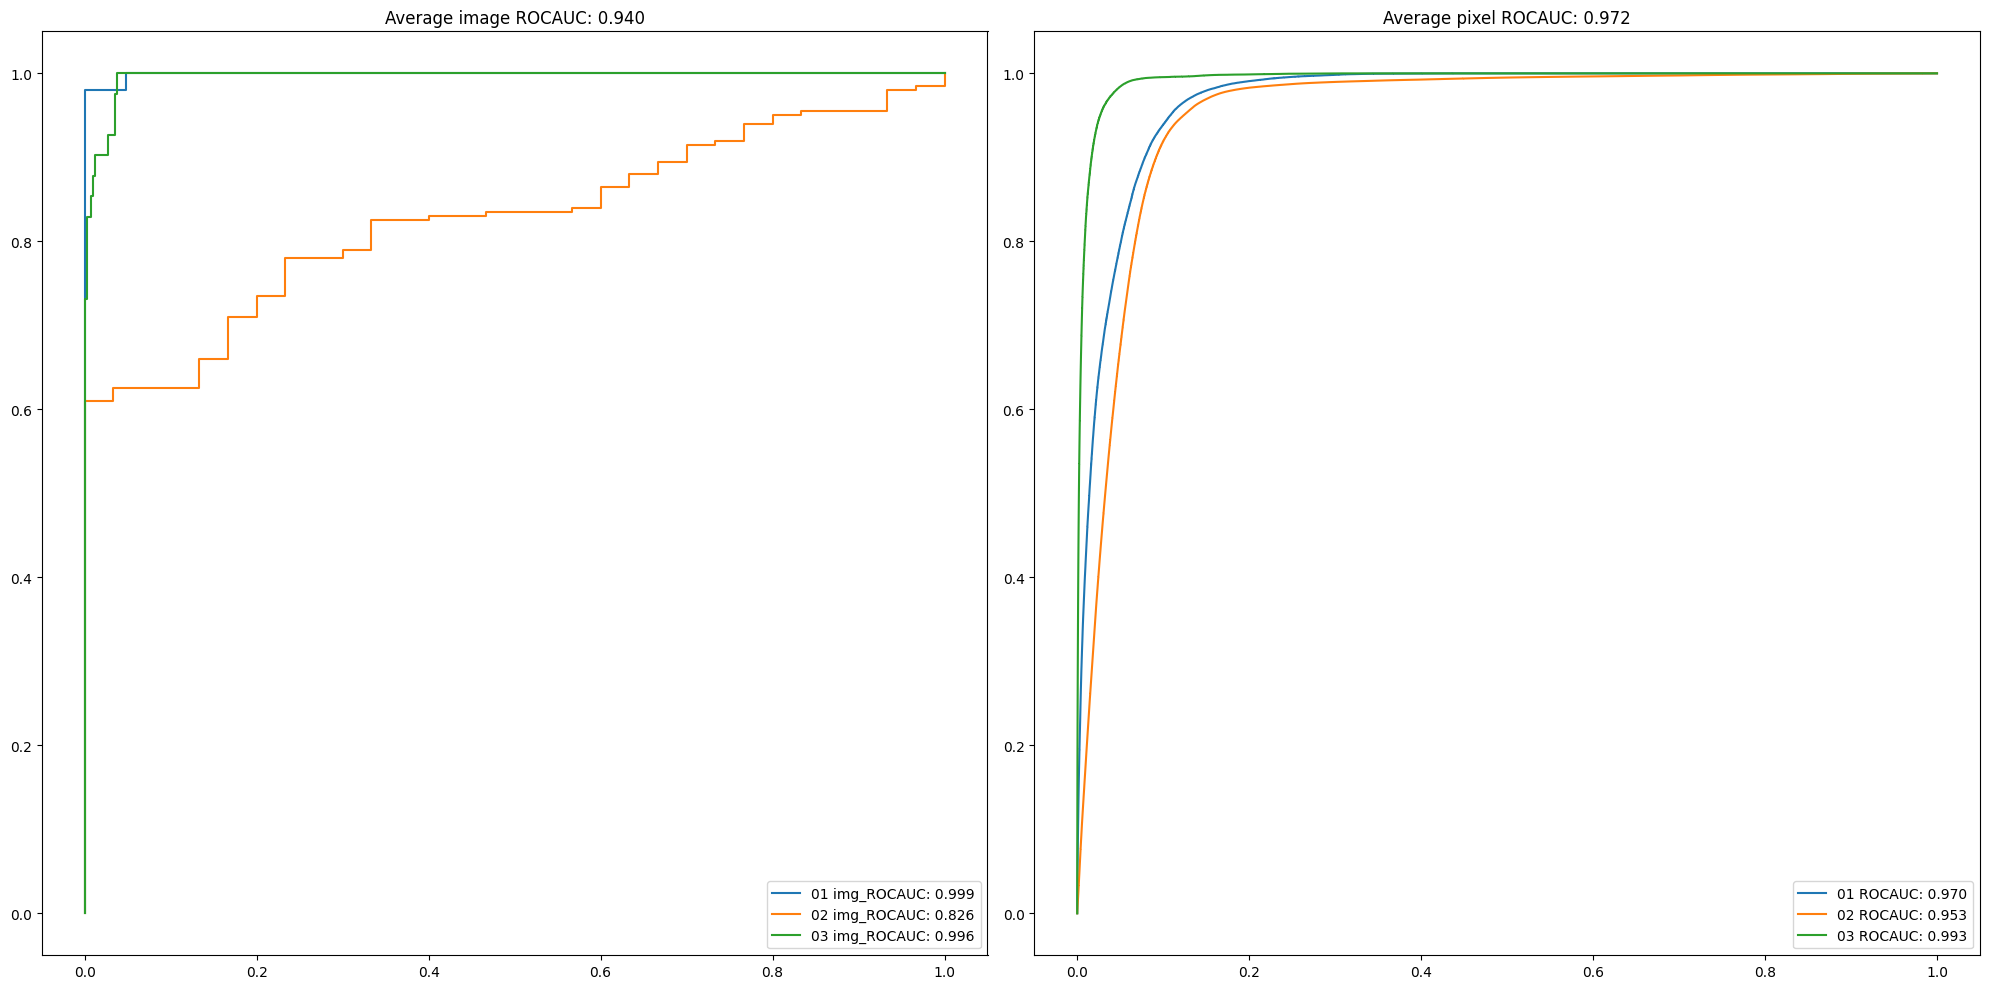

In [12]:
main()